In [5]:
%matplotlib inline

# SLD gradients

For the moment, BornAgain does not support input of SLD profiles. However, one can approximate the smooth SLD profile by a large number of layers. See the example script below.

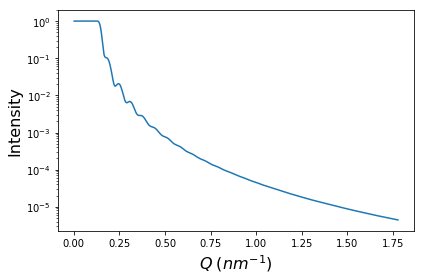

In [6]:
# %load density_grad.py
import numpy as np
import bornagain as ba
from bornagain import deg, angstrom, nm

# define used SLDs
sld_D2O = 6.34e-06
sld_polymer = 4.0e-06
sld_Si = 2.07e-06

h = 100.0*nm   # thickness of the non-uniform polymer layer

nslices = 100  # number of slices to slice the polymer layer


def get_sld(z):
    """
    function to calculate SLD(z) for the polymer layer
    """
    return sld_polymer*np.exp(-z/h)


def add_slices(multilayer):
    dz = h/nslices
    zvals = np.linspace(0, h, nslices, endpoint=False) + 0.5*dz
    for z in zvals:
        sld = get_sld(z)
        material = ba.MaterialBySLD("Polymer_{:.1f}".format(z), sld, 0.0)
        layer = ba.Layer(material, dz)
        multilayer.addLayer(layer)


def get_sample():
    # Defining Materials
    m_Si = ba.MaterialBySLD("Si", sld_Si, 0.0)
    m_Polymer = ba.MaterialBySLD("Polymer-0", sld_polymer, 0.0)
    m_D2O = ba.MaterialBySLD("D2O", sld_D2O, 0.0)

    # Defining Layers
    layer_si = ba.Layer(m_Si)
    layer_polymer = ba.Layer(m_Polymer, 2.0*nm)
    layer_d2o = ba.Layer(m_D2O)

    # Defining Multilayers
    multiLayer = ba.MultiLayer()
    multiLayer.addLayer(layer_si)
    multiLayer.addLayer(layer_polymer)
    add_slices(multiLayer)
    multiLayer.addLayer(layer_d2o)
    return multiLayer


def get_simulation():
    simulation = ba.SpecularSimulation()
    alpha_i_axis = ba.FixedBinAxis("alpha_i", 500, 0.0*deg, 6.5*deg)
    simulation.setBeamParameters(8.0*angstrom, alpha_i_axis)
    simulation.setBeamIntensity(1.0)
    # add wavelength distribution
    distr_1 = ba.DistributionCosine(8.0*angstrom, 0.8*angstrom/2.355)
    simulation.addParameterDistribution("*/Beam/Wavelength", distr_1, 50, 2.0, ba.RealLimits.positive())
    return simulation


def run_simulation():
    sample = get_sample()
    simulation = get_simulation()
    simulation.setSample(sample)
    simulation.runSimulation()
    return simulation.result()


if __name__ == '__main__':
    results = run_simulation()
    ba.plot_simulation_result(results, units=ba.AxesUnits.QSPACE)


## Exercise

Play with the script above. Change the function for SLD profile, add/remove/vary the beam divergence. How does it influence the simulation result?

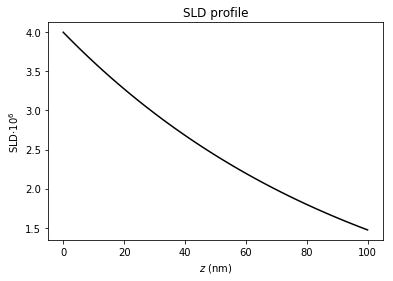

In [3]:
# plot an SLD profile
import matplotlib.pyplot as plt
x = np.linspace(0, h, nslices)
y = get_sld(x)

plt.plot(x, y*1e+6, color='k')
plt.xlabel(r'$z$ (nm)')
plt.ylabel(r'SLD$\cdot 10^6$')
plt.title("SLD profile");

# Diffuse scattering: disordered samples


![Diffuse scattering](img/galaxi_sample.png)

Understanding the diffuse scattering in GISAS is a challenging task. The reason of the diffuse scattering is any kind of disorder in the sample.

**Possible reasons of diffuse scattering**
- Particle size distribution
- Different kinds of particles
- Disordered particle layout
- Variety of particle rotations
- Variety of lattice rotation
- Polymer density fluctuations 


## Particle rotation

Let's take the [Rotated Pyramids](https://www.bornagainproject.org/documentation/sample-models/embedded-particles/rotated-pyramids/) example and modiy it to account for rotational distribution of particles. First, we increase a bit the size of pyramids to get nicer images. Set the pyramid `BaseEdge` to be 40 nm and the pyramid `Height` to 20 nm:

```python
pyramid_ff = ba.FormFactorPyramid(40*nm, 20*nm, 54.73*deg)
```
and run the script below.

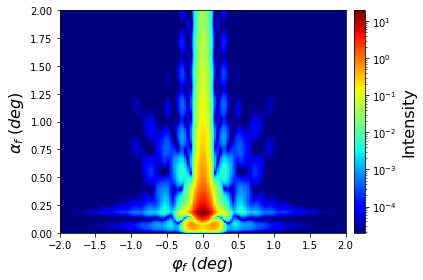

In [4]:
# %load https://www.bornagainproject.org/files/python/simulation/ex01_BasicParticles/RotatedPyramids.py
"""
Rotated pyramids on top of substrate
"""
import bornagain as ba
from bornagain import deg, angstrom, nm


def get_sample():
    """
    Returns a sample with rotated pyramids on top of a substrate.
    """
    # defining materials
    m_ambience = ba.HomogeneousMaterial("Air", 0.0, 0.0)
    m_substrate = ba.HomogeneousMaterial("Substrate", 6e-6, 2e-8)
    m_particle = ba.HomogeneousMaterial("Particle", 6e-4, 2e-8)

    # collection of particles
    pyramid_ff = ba.FormFactorPyramid(40*nm, 20*nm, 54.73*deg)
    pyramid = ba.Particle(m_particle, pyramid_ff)
    transform = ba.RotationZ(45.*deg)
    particle_layout = ba.ParticleLayout()
    particle_layout.addParticle(
        pyramid, 1.0, ba.kvector_t(0.0, 0.0, 0.0), transform)

    air_layer = ba.Layer(m_ambience)
    air_layer.addLayout(particle_layout)
    substrate_layer = ba.Layer(m_substrate)

    multi_layer = ba.MultiLayer()
    multi_layer.addLayer(air_layer)
    multi_layer.addLayer(substrate_layer)
    return multi_layer


def get_simulation():
    """
    Returns a GISAXS simulation with beam and detector defined.
    """
    simulation = ba.GISASSimulation()
    simulation.setDetectorParameters(200, -2.0*deg, 2.0*deg,
                                     200, 0.0*deg, 2.0*deg)
    simulation.setBeamParameters(1.0*angstrom, 0.2*deg, 0.0*deg)
    return simulation


def run_simulation():
    """
    Runs simulation and returns intensity map.
    """
    simulation = get_simulation()
    simulation.setSample(get_sample())
    simulation.runSimulation()
    return simulation.result()


if __name__ == '__main__':
    result = run_simulation()
    ba.plot_simulation_result(result)


## Exercise

Add the rotational distribution. If got stucked, see the [solution](RotatedPyramids.py) or just run the line below.

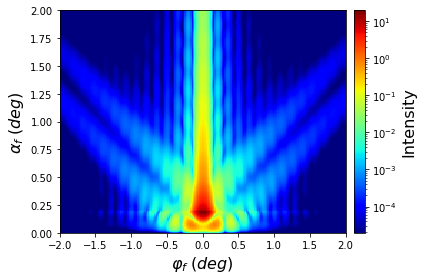

In [17]:
%load RotatedPyramids.py

## Lattice rotation

Imaging techniques deliver information from a few $\mu m^2$, while GISAS typically averages the information over the whole sample surface. This explains the effect of diffuse scattering for samples that look well ordered on SEM/AFM images.

Let's take a [BornAgain example](https://www.bornagainproject.org/documentation/sample-models/interference-functions/spheres-at-hex-lattice/) and modify it to account for variety of lattice rotations.

First, we increase a bit lattice length to see more peaks and `DecayLengths` of the decay function to make peaks more narrow:

```python
interference = ba.InterferenceFunction2DLattice.createHexagonal(35.0*nm)
pdf = ba.FTDecayFunction2DCauchy(100*nm, 100*nm)
```

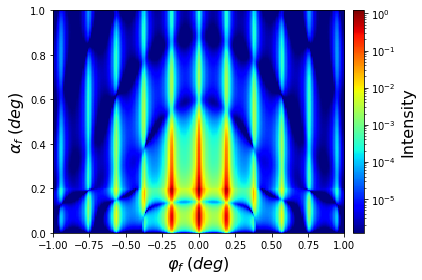

In [27]:
# %load https://www.bornagainproject.org/files/python/simulation/ex03_InterferenceFunctions/SpheresAtHexLattice.py
"""
Spheres on a hexagonal lattice
"""
import bornagain as ba
from bornagain import deg, angstrom, nm


def get_sample():
    """
    Returns a sample with spherical particles on a substrate,
    forming a hexagonal 2D lattice.
    """
    m_air = ba.HomogeneousMaterial("Air", 0.0, 0.0)
    m_substrate = ba.HomogeneousMaterial("Substrate", 6e-6, 2e-8)
    m_particle = ba.HomogeneousMaterial("Particle", 6e-4, 2e-8)

    sphere_ff = ba.FormFactorFullSphere(10.0*nm)
    sphere = ba.Particle(m_particle, sphere_ff)
    particle_layout = ba.ParticleLayout()
    particle_layout.addParticle(sphere)

    interference = ba.InterferenceFunction2DLattice.createHexagonal(35.0*nm)
    pdf = ba.FTDecayFunction2DCauchy(100*nm, 100*nm)
    interference.setDecayFunction(pdf)

    particle_layout.setInterferenceFunction(interference)

    air_layer = ba.Layer(m_air)
    air_layer.addLayout(particle_layout)
    substrate_layer = ba.Layer(m_substrate, 0)
    multi_layer = ba.MultiLayer()
    multi_layer.addLayer(air_layer)
    multi_layer.addLayer(substrate_layer)
    return multi_layer


def get_simulation():
    """
    Create and return GISAXS simulation with beam and detector defined
    """
    simulation = ba.GISASSimulation()
    simulation.setDetectorParameters(200, -1.0*deg, 1.0*deg,
                                     200, 0.0*deg, 1.0*deg)
    simulation.setBeamParameters(1.0*angstrom, 0.2*deg, 0.0*deg)
    return simulation


def run_simulation():
    """
    Runs simulation and returns intensity map.
    """
    simulation = get_simulation()
    simulation.setSample(get_sample())
    simulation.runSimulation()
    return simulation.result()


if __name__ == '__main__':
    result = run_simulation()
    ba.plot_simulation_result(result)


### Exercise

Modify the script above to account for the lattice rotational distribution. Let's distribute lattice rotation angles using Gaussian PDF.

**Hint:** the code below helps to get the list of sample parameters

In [28]:
sample = get_sample()
print(sample.parametersToString())

'/MultiLayer/CrossCorrelationLength':0
'/MultiLayer/ExternalFieldX':0
'/MultiLayer/ExternalFieldY':0
'/MultiLayer/ExternalFieldZ':0
'/MultiLayer/Layer0/ParticleLayout/Weight':1
'/MultiLayer/Layer0/ParticleLayout/Particle/Abundance':1
'/MultiLayer/Layer0/ParticleLayout/Particle/PositionX':0
'/MultiLayer/Layer0/ParticleLayout/Particle/PositionY':0
'/MultiLayer/Layer0/ParticleLayout/Particle/PositionZ':0
'/MultiLayer/Layer0/ParticleLayout/Particle/FullSphere/Radius':10
'/MultiLayer/Layer0/ParticleLayout/Interference2DLattice/FTDecayFunction2DCauchy/DecayLengthX':100
'/MultiLayer/Layer0/ParticleLayout/Interference2DLattice/FTDecayFunction2DCauchy/DecayLengthY':100
'/MultiLayer/Layer0/ParticleLayout/Interference2DLattice/FTDecayFunction2DCauchy/Gamma':0
'/MultiLayer/Layer0/ParticleLayout/Interference2DLattice/HexagonalLattice/LatticeLength':35
'/MultiLayer/Layer0/ParticleLayout/Interference2DLattice/HexagonalLattice/Xi':0




### Solution

See the [solution](rotated_lattice.py) or just run the line below.

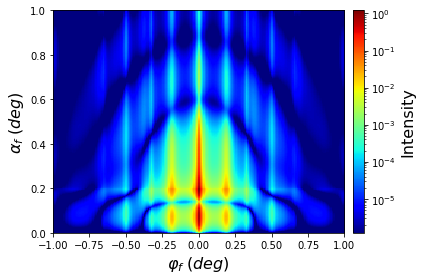

In [30]:
%load rotated_lattice.py

For ordered samples, peak on the detector is observed when the reciprocal lattice is aligned so that the **Ewald sphere intersects the peak**. Thus, lattice rotations cause additional peaks at the GISAS pattern. 

Feel free to play with the example: change the kind of the distribution, add the beam divergence. How does it influence the simulation result?

## Polymer density fluctuations 

Polymer density fluctuations smear out the peaks an cause a lot of diffuse scattering. Example GISANS partern is shown in the figure below \[1\]. 

[![Diffuse GISANS](img/diffuse_polymer.jpg)](https://doi.org/10.1016/j.physb.2018.03.049)


Figure below illustrates kinds of inhomogenities in polymer solutions. Blobs of polymer chains are represented as black lines and blobs of crosslinks with red dots.

[![Inhomogenities](img/inhomogenities.jpg)](https://www.nature.com/articles/pj2010110#f3)
Schematic representations of (a) a two-dimensional reaction bath well above the chain gelation threshold, (b) an overswollen gel by the addition of solvent and (c) dynamic, static and total concentration fluctuations with space coordinate r. For the sake of simplicity, the chains, which are random walks on this lattice, are not shown in the figure. Black dots represent the interchain crosslinks placed at random  \[2\]. 

These inhomogenities account for the diffuse scattering. To take them into account, two form factors are available in BornAgain:

### Form factor Ornstein-Zernike

**Born** form factor is implemented in BornAgain as

$$F_{OZ}(\mathbf{q}) = \sqrt{\frac{I_0}{1 + \xi_{xy}^2\cdot(q_x^2 + q_y^2) + \xi_z^2\cdot q_z^2}}$$

where $\xi_{xy}$ and $\xi_z$ represent inhomogenity *blob* size (in nm) in azimuthal and vertical directions, respectively.

To create the Ornstein-Zernike form factor, use statement

```python
import bornagain as ba
myff = ba.FormFactorOrnsteinZernike(I0, xi_xy, xi_z)
```


### Form factor Debye-Buche

**Born** form factor is implemented in BornAgain as

$$F_{DB}(\mathbf{q}) = \frac{\sqrt{I_0}}{1 + \xi^2\cdot|\mathbf{q}|^2}$$

To create it, use statement

```python
import bornagain as ba
myff = ba.FormFactorDebyeBueche(I0, xi)
```

### Example script

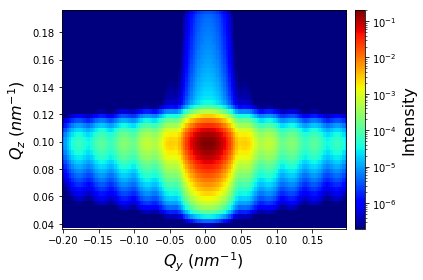

In [15]:
# %load polymer.py
import numpy as np
import bornagain as ba
from bornagain import deg, angstrom, nm

# KWS-1 detector parameters
npx, npy = 128, 128   # number of detector pixels
psize = 5.3  # pixel size, mm
det_width, det_height = npx*psize, npy*psize  # mm, detector size
sdd = 20000.0     # mm, sample-detector distance

# direct beam position
beam_xpos, beam_ypos = 64.5, 64.5       # pixel

# incident angle
ai = 0.2   # degree
wavelength = 5.0  # angstrom

# beam
beam_intensity = 1.0

# SLDs
sld_Si = 2.074e-6
sld_Si_im = -2.3819e-11
sld_D2O = 6.356e-6
sld_D2O_im = -1.1295e-13
sld_polymer = 4.0e-6
sld_polymer_im = 0.0


def get_sample():
    """
    Returns a sample
    """
    # defining materials
    m_si = ba.MaterialBySLD("Si", sld_Si, sld_Si_im)
    m_d2o = ba.MaterialBySLD("D2O", sld_D2O, sld_D2O_im)
    m_polymer = ba.MaterialBySLD("Polymer", sld_polymer, sld_polymer_im)

    # particle layout
    microgel_layout = ba.ParticleLayout()

    # weights for components
    w_particles = 0.005
    w_oz =0.5
    w_db = 1.0 - w_oz - w_particles

    # fluctuation component
    ff_oz = ba.FormFactorOrnsteinZernike(1000, 10.0*nm, 5.0*nm)
    particle_oz = ba.Particle(m_polymer, ff_oz)
    microgel_layout.addParticle(particle_oz, w_oz)

    # Debye-Buche component
    ff_db = ba.FormFactorDebyeBueche(1000, 20.0*nm)
    particle_db = ba.Particle(m_polymer, ff_db)
    microgel_layout.addParticle(particle_db, w_db)

    # collection of particles
    radius = 100.0*nm
    ff = ba.FormFactorTruncatedSphere(radius=radius, height=radius)
    particle = ba.Particle(m_polymer, ff)
    particle.setPosition(ba.kvector_t(0.0, 0.0, -1.0*radius))
    microgel_layout.addParticle(particle, w_particles)

    # no interference function
    interference = ba.InterferenceFunctionNone()
    microgel_layout.setInterferenceFunction(interference)
    microgel_layout.setTotalParticleSurfaceDensity(1e-6)

    d2o_layer = ba.Layer(m_d2o)
    d2o_layer.addLayout(microgel_layout)
    si_layer = ba.Layer(m_si)
    multi_layer = ba.MultiLayer()
    multi_layer.addLayer(si_layer)
    multi_layer.addLayer(d2o_layer)

    return multi_layer


def create_detector():
    """
    Creates and returns KWS-1 detector
    """
    u0 = beam_xpos*psize  # in mm
    v0 = beam_ypos*psize  # in mm
    detector = ba.RectangularDetector(npx, det_width, npy, det_height)
    detector.setPerpendicularToDirectBeam(sdd, u0, v0)
    return detector


def get_simulation(wl=5.0, alpha_i=ai):
    """
    Returns a GISAS simulation with beam and detector defined
    """
    simulation = ba.GISASSimulation()
    simulation.setBeamParameters(wl*ba.angstrom, alpha_i*ba.deg, 0.0*ba.deg)
    simulation.setDetector(create_detector())
    simulation.setBeamIntensity(beam_intensity)
    return simulation


def run_simulation():
    """
    Runs simulation and returns resulting intensity map.
    """
    sample = get_sample()
    simulation = get_simulation(wavelength)
    simulation.setDetectorResolutionFunction(ba.ResolutionFunction2DGaussian(2.0*psize, 1.0*psize))
    simulation.setSample(sample)
    simulation.setRegionOfInterest(20, 400, 650, 650)
    # options
    simulation.getOptions().setUseAvgMaterials(True)
    #simulation.getOptions().setIncludeSpecular(True)
    simulation.setTerminalProgressMonitor()
    simulation.runSimulation()
    return simulation.result()


if __name__ == '__main__':
    result = run_simulation()
    ba.plot_simulation_result(result, units=ba.AxesUnits.QSPACE)


### What this script simulates

Considering [decoupling approximation](../../day_1/gisas_theory_W/GISAS_theory.ipynb#3.2.2-The-decoupling-approximation), the scattered intensity is:

$$\frac{1}{N}\left\langle\frac{d\sigma}{d\Omega}(\mathbf{k_i}, \mathbf{k_f})\right\rangle = \left\langle \left| \mathcal F_\alpha \right|^2 \right\rangle_\alpha - \left|\left\langle \mathcal F_\alpha \right\rangle_\alpha \right|^2 + \left|\left\langle \mathcal F_\alpha \right\rangle_\alpha \right|^2  S(\mathbf q)$$

In this example, we ignore the interference function. This is applicable for a dilute polymer solutions where distance between microgel particles an in the range of $\mu$m. Thus, $S(\mathbf q)=1$ and consequently,

$$\frac{1}{N}\left\langle\frac{d\sigma}{d\Omega}(\mathbf{k_i}, \mathbf{k_f})\right\rangle = \left\langle \left| \mathcal F_\alpha \right|^2 \right\rangle_\alpha$$

Since $\left\langle \left| \mathcal F_\alpha \right|^2 \right\rangle_\alpha$ stands for the averaging over the kinds of particles, for 3 form factors used in the example script it can be expanded as

$$\left\langle \left| \mathcal F_\alpha \right|^2 \right\rangle_\alpha = w_{particle}\left| \mathcal F_{particle} \right|^2 + w_{OZ}\left| \mathcal F_{OZ} \right|^2 + w_{DB}\left| \mathcal F_{DB} \right|^2$$

where $\mathcal F_i$ are the **DWBA** form factors and $w_i$ are the corresponding weights. 

Finally, the line

```python
simulation.setDetectorResolutionFunction(ba.ResolutionFunction2DGaussian(2.0*psize, 1.0*psize))
```
adds a convolution of the calculated scattering intensity to the 2D Gaussian.

## References

[[1]](https://doi.org/10.1016/j.physb.2018.03.049) T. Kyrey et. al. *Physica B: Condensed Matter*, **551** (2018), pp. 172-178,

[[2]](https://www.nature.com/articles/pj2010110) M. Shibayama, *Polymer Journal* **43** (2011), pp 18–34 